# **Automatic text Generation using Tensorflow**

## Import Libraries

In [30]:
import tensorflow as tf
import string
import requests

## Import data

In [31]:
response = requests.get('https://ocw.mit.edu/ans7870/6/6.006/s08/lecturenotes/files/t8.shakespeare.txt')
response.text[:1500]


'This is the 100th Etext file presented by Project Gutenberg, and\nis presented in cooperation with World Library, Inc., from their\nLibrary of the Future and Shakespeare CDROMS.  Project Gutenberg\noften releases Etexts that are NOT placed in the Public Domain!!\n\nShakespeare\n\n*This Etext has certain copyright implications you should read!*\n\n<<THIS ELECTRONIC VERSION OF THE COMPLETE WORKS OF WILLIAM\nSHAKESPEARE IS COPYRIGHT 1990-1993 BY WORLD LIBRARY, INC., AND IS\nPROVIDED BY PROJECT GUTENBERG ETEXT OF ILLINOIS BENEDICTINE COLLEGE\nWITH PERMISSION.  ELECTRONIC AND MACHINE READABLE COPIES MAY BE\nDISTRIBUTED SO LONG AS SUCH COPIES (1) ARE FOR YOUR OR OTHERS\nPERSONAL USE ONLY, AND (2) ARE NOT DISTRIBUTED OR USED\nCOMMERCIALLY.  PROHIBITED COMMERCIAL DISTRIBUTION INCLUDES BY ANY\nSERVICE THAT CHARGES FOR DOWNLOAD TIME OR FOR MEMBERSHIP.>>\n\n*Project Gutenberg is proud to cooperate with The World Library*\nin the presentation of The Complete Works of William Shakespeare\nfor your

In [32]:
data = response.text.split('\n')
data[0]

'This is the 100th Etext file presented by Project Gutenberg, and'

In [33]:
data = data[253:2799]
data[0]

'  From fairest creatures we desire increase,'

In [34]:
data = " ".join(data) #removes newline character
data[:1000]

"  From fairest creatures we desire increase,   That thereby beauty's rose might never die,   But as the riper should by time decease,   His tender heir might bear his memory:   But thou contracted to thine own bright eyes,   Feed'st thy light's flame with self-substantial fuel,   Making a famine where abundance lies,   Thy self thy foe, to thy sweet self too cruel:   Thou that art now the world's fresh ornament,   And only herald to the gaudy spring,   Within thine own bud buriest thy content,   And tender churl mak'st waste in niggarding:     Pity the world, or else this glutton be,     To eat the world's due, by the grave and thee.                        2   When forty winters shall besiege thy brow,   And dig deep trenches in thy beauty's field,   Thy youth's proud livery so gazed on now,   Will be a tattered weed of small worth held:     Then being asked, where all thy beauty lies,   Where all the treasure of thy lusty days;   To say within thine own deep sunken eyes,   Were an al

##Data Cleaning

In [35]:
def clean_text(doc):
  tokens = doc.split()
  table = str.maketrans('', '', string.punctuation)
  tokens = [w.translate(table) for w in tokens]
  tokens = [word for word in tokens if word.isalpha()]
  tokens = [word.lower() for word in tokens]
  return tokens

tokens = clean_text(data)
print(tokens[:50])

['from', 'fairest', 'creatures', 'we', 'desire', 'increase', 'that', 'thereby', 'beautys', 'rose', 'might', 'never', 'die', 'but', 'as', 'the', 'riper', 'should', 'by', 'time', 'decease', 'his', 'tender', 'heir', 'might', 'bear', 'his', 'memory', 'but', 'thou', 'contracted', 'to', 'thine', 'own', 'bright', 'eyes', 'feedst', 'thy', 'lights', 'flame', 'with', 'selfsubstantial', 'fuel', 'making', 'a', 'famine', 'where', 'abundance', 'lies', 'thy']


##Data Exploration

In [36]:
len(tokens)

17123

In [37]:
len(set(tokens)) #unique tokens

3121

To be precise we are going to use a set of 50 words to predict the 51st word. Hence we are going to divide our data in chunks of 51 words and at the last we will separate the last word from every line. We are going to limit our dataset to 200000 words.

In [38]:
length = 50 + 1
lines = []

for i in range(length, len(tokens)):
  seq = tokens[i-length:i]
  line = ' '.join(seq)
  lines.append(line)
  if i > 200000:
    break

print(len(lines))

17072


Now we will see the first line consisting of 51 words.

In [39]:
lines[0]

'from fairest creatures we desire increase that thereby beautys rose might never die but as the riper should by time decease his tender heir might bear his memory but thou contracted to thine own bright eyes feedst thy lights flame with selfsubstantial fuel making a famine where abundance lies thy self'

In [40]:
tokens[50]

'self'

##Model Building

In [41]:
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import ModelCheckpoint

Tokenization : to create a unique numerical token for each unique word in the dataset.

In [42]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(lines)
sequences = tokenizer.texts_to_sequences(lines)
sequences = np.array(sequences)
X, y = sequences[:, :-1], sequences[:,-1] #split each line such that the first 50 words are in X and the last word is in y.
X[0]

array([  35,  611, 1321,  171,  244,  610,    7, 1320,  138,  399,  104,
        170,  205,   16,   22,    2, 1319,   64,   32,   51,  833,   28,
        333,  832,  104,  204,   28,  297,   16,   10, 1318,    3,   63,
         86,  223,   50, 3119,    9, 3118,  830,   11, 3116, 3115,  203,
         18, 3114,   72,  608,  222,    9])

In [43]:
vocab_size = len(tokenizer.word_index) + 1 #contains all the uniques words in the dataset.

In [44]:
y = to_categorical(y, num_classes=vocab_size) # converts a class vector (integers) to binary class matrix. 

In [45]:
seq_length = X.shape[1]
seq_length

50

LSTM Model

In [46]:
model = Sequential()
model.add(Embedding(vocab_size, 50, input_length=seq_length))
model.add(LSTM(100, return_sequences=True))
model.add(LSTM(100))
model.add(Dense(100, activation='relu'))
model.add(Dense(vocab_size, activation='softmax'))

In [47]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 50, 50)            156100    
                                                                 
 lstm_2 (LSTM)               (None, 50, 100)           60400     
                                                                 
 lstm_3 (LSTM)               (None, 100)               80400     
                                                                 
 dense_2 (Dense)             (None, 100)               10100     
                                                                 
 dense_3 (Dense)             (None, 3122)              315322    
                                                                 
Total params: 622,322
Trainable params: 622,322
Non-trainable params: 0
_________________________________________________________________


In [48]:
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
filepath = "./model_2_weights.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

In [49]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')



[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [50]:
history = model.fit(np.asarray(X), y, batch_size = 128, epochs = 100,callbacks = callbacks_list,verbose = 1)

Epoch 1/100
134/134 [==============================] - ETA: 0s - loss: 6.8574 - accuracy: 0.0221
Epoch 1: loss improved from inf to 6.85738, saving model to ./model_2_weights.hdf5
134/134 [==============================] - 24s 143ms/step - loss: 6.8574 - accuracy: 0.0221
Epoch 2/100
134/134 [==============================] - ETA: 0s - loss: 6.4652 - accuracy: 0.0263
Epoch 2: loss improved from 6.85738 to 6.46524, saving model to ./model_2_weights.hdf5
134/134 [==============================] - 10s 76ms/step - loss: 6.4652 - accuracy: 0.0263
Epoch 3/100
134/134 [==============================] - ETA: 0s - loss: 6.3842 - accuracy: 0.0275
Epoch 3: loss improved from 6.46524 to 6.38422, saving model to ./model_2_weights.hdf5
134/134 [==============================] - 6s 45ms/step - loss: 6.3842 - accuracy: 0.0275
Epoch 4/100
134/134 [==============================] - ETA: 0s - loss: 6.3121 - accuracy: 0.0277
Epoch 4: loss improved from 6.38422 to 6.31206, saving model to ./model_2_weights.

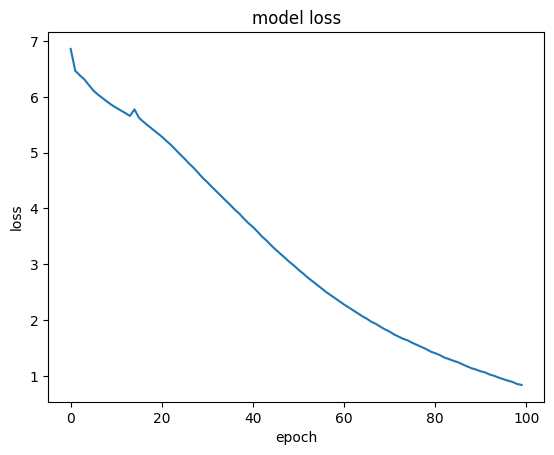

In [51]:
import matplotlib.pyplot as plt
plt.plot(history.history["loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.show()

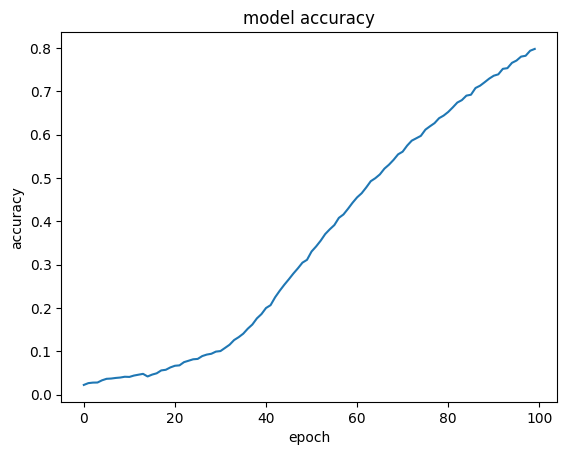

In [52]:
import matplotlib.pyplot as plt
plt.plot(history.history["accuracy"])
plt.title("model accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.show()

We are now going to generate words using the model. For this we need a set of 50 words to predict the 51st word. So we are taking a random line.

In [64]:
seed_text=lines[828]
seed_text

'in each by mutual ordering resembling sire and child and happy mother who all in one one pleasing note do sing whose speechless song being many seeming one sings this to thee thou single wilt prove none is it for fear to wet a widows eye that thou consumst thy self'

generate_text_seq() generates n_words number of words after the given seed_text. We are going to pre-process the seed_text before predicting. We are going to encode the seed_text using the same encoding used for encoding the training data. Then we are going to convert the seed_textto 50 words by using pad_sequences(). Now we will predict using model.predict_classes(). After that we will search the word in tokenizer using the index in y_predict. Finally we will append the predicted word to seed_text and text and repeat the process.


gen() takes a string input, tokenizes it, then pads it with zeroes so it fits into our 100 long prediction window.


In [66]:
reverse_word_map = dict(map(reversed, tokenizer.word_index.items()))

In [67]:
def gen(model,tokenizer,seq,max_len):
    ''' Generates a sequence given a string seq using specified model until the total sequence length
    reaches max_len'''
    # Tokenize the input string
    tokenized_sent = tokenizer.texts_to_sequences([seq])
    max_len = max_len+len(tokenized_sent[0])
    # If sentence is not as long as the desired sentence length, we need to 'pad sequence' so that
    # the array input shape is correct going into our LSTM. the `pad_sequences` function adds 
    # zeroes to the left side of our sequence until it becomes 19 long, the number of input features.
    while len(tokenized_sent[0]) < max_len:
        padded_sentence = pad_sequences(tokenized_sent[-50:],maxlen=50)
        op = model.predict(np.asarray(padded_sentence).reshape(1,-1))
        tokenized_sent[0].append(op.argmax()+1)
        
    return " ".join(map(lambda x : reverse_word_map[x],tokenized_sent[0]))

In [68]:
gen(model,tokenizer,seed_text,100)

1/1 [==============================] - 0s 22ms/step


'in each by mutual ordering resembling sire and child and happy mother who all in one one pleasing note do sing whose speechless song being many seeming one sings this to thee thou single wilt prove none is it for fear to wet a widows eye that thou consumst thy self thy plea female without muse man you even not these there than loves better fool his alter none you from more black stop men all hath is then be dost with that be dost that my course account the his none who even my life all when fawn stay from of let a barren resembling report or most thou form i buried compared the me in doth jewel gone fill youth music all well know all my hast part be or thou gainst eye verse more dear scythe not fair advantage his alter thy so let that art music on'